In [1]:
import os
from pathlib import Path
from PIL import Image
import cv2
import numpy as np
import json
from shapely.geometry import Polygon
import image_slicer
import time

# DeepLab code:
# taken from https://gluon-cv.mxnet.io/build/examples_segmentation/demo_deeplab.html
# dataset description https://groups.csail.mit.edu/vision/datasets/ADE20K/, https://github.com/dmlc/gluon-cv/blob/master/gluoncv/data/ade20k/segmentation.py
# deeplab code https://github.com/dmlc/gluon-cv/blob/master/gluoncv/model_zoo/deeplabv3.py

import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
import gluoncv
from gluoncv.data.transforms.presets.segmentation import test_transform
# using cpu
ctx = mx.cpu(0)

# OCR code
import pytesseract
from pytesseract import Output


# If you don't have tesseract executable in your PATH, include the following:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' # Path('C:/Program Files\ Tesseract-OCR\ tesseract').as_posix()


# Scene recognition imports
from Keras_VGG16_places365.vgg16_places_365 import VGG16_Places365
from cv2 import resize


import evaluation_utils as eval_u
import deeplab_utils as dl_u

Using TensorFlow backend.


In [2]:
#image_list_deeplab, list_image_names_deeplab, list_ratio = eval_u.prepare_dataset('../small_10_test2017/', 'deeplab', True)
image_list_deeplab, list_image_names_deeplab, list_ratio, list_shapes = eval_u.prepare_dataset('../1_test2017/', 'deeplab', True)

In [3]:
model_deeplab = eval_u.load_model('deeplab')
output_pred_deeplab = eval_u.get_predictions(image_list_deeplab, 'deeplab', model_deeplab)

Currently treating image number  1
predicting
calculating labels
calculating probabilities.


In [4]:
print(output_pred_deeplab[0][0].shape)
print(output_pred_deeplab[0][1].shape)

(1, 150, 512, 682)
(512, 682)


In [5]:
#outp = mx.nd.squeeze(mx.nd.argmax(output_pred_deeplab[0], 1)).asnumpy()
print(output_pred_deeplab[0][1].shape)
print(type(output_pred_deeplab[0][1]))
#print(np.unique(output_pred_deeplab[0][1]))

(512, 682)
<class 'mxnet.ndarray.ndarray.NDArray'>


In [6]:
# Resizing image test

#from skimage.transform import resize
#testresize = resize(output_pred_deeplab[0][1].asnumpy(), (list_shapes[0][0], list_shapes[0][1]))
#print(testresize.shape)
#print(testresize)

In [7]:
# Test output with probabilities
output = dl_u.deeplab_pred_to_output(output_pred_deeplab[0][1], False, True, output_pred_deeplab[0][0], True, list_shapes[0])


Creating masks.
Resizing image prediction.
Number of classes with masks to create:  8
Number of classes with masks to create:  8


In [8]:
output = dl_u.deeplab_pred_to_output(output_pred_deeplab[0][1])

Creating masks.
Number of classes with masks to create:  8


In [9]:
# Restructure to obtain data image per image instead of loading everything.
path_image_folder = '../1_test2017/'
pathlist = Path(path_image_folder).glob('**/*.*')


list_img = []
list_img_name = []
list_img_ratio = []
list_img_shapes = []
list_output = []
for path in pathlist:
    start = time.time()
    print(path)
    # Read data
    #image_list_deeplab, list_image_names_deeplab, list_ratio, list_shapes = eval_u.prepare_dataset('../1_test2017/', 'deeplab', True)
    img, img_name, img_ratio, img_shapes = eval_u.prepare_sample(path, 'deeplab', True)
    # Get predictions
    model_deeplab = eval_u.load_model('deeplab')
    output_pred_deeplab = eval_u.get_predictions([img], 'deeplab', model_deeplab)
    # Post process to polygon
    #output = dl_u.deeplab_pred_to_output(output_pred_deeplab[0][1], False, True, output_pred_deeplab[0][0])
    output = dl_u.deeplab_pred_to_output(output_pred_deeplab[0][1], False, True, output_pred_deeplab[0][0], True, img_shapes)
    list_img.append(img)
    list_img_name.append(img_name)
    list_img_ratio.append(img_ratio)
    list_img_shapes.append(img_shapes)
    list_output.append(output)
    end = time.time()
    print("Time to process image: ", end - start)

..\1_test2017\2017_12571467.jpg
Currently treating image number  1
predicting
calculating labels
calculating probabilities.
Creating masks.
Resizing image prediction.
Number of classes with masks to create:  8
Number of classes with masks to create:  8
Time to process image:  102.91516518592834


In [10]:
"""
# Getting confidence for polygon.
print(output[0])
x, y = output[0][0][0].exterior.coords.xy
print(list(output[0][0][0].exterior.coords.xy))
print((np.frombuffer(x).astype(int)), np.frombuffer(y).astype(int))
x = np.frombuffer(x).astype(int)
y = np.frombuffer(y).astype(int)

from scipy.ndimage.morphology import binary_fill_holes as imfill

mask = np.zeros((image_list_deeplab[0].shape[2], image_list_deeplab[0].shape[3]),dtype=bool)
mask[x, y] = 1
img_proba = output_pred_deeplab[0][0][0, output[0][2], :, :]
out = img_proba[imfill(mask)].sum() / img_proba[imfill(mask)].shape[0]

mask.shape
print(np.unique(mask))
print(imfill(mask))
print(img_proba[imfill(mask)])
print(out)
"""

'\n# Getting confidence for polygon.\nprint(output[0])\nx, y = output[0][0][0].exterior.coords.xy\nprint(list(output[0][0][0].exterior.coords.xy))\nprint((np.frombuffer(x).astype(int)), np.frombuffer(y).astype(int))\nx = np.frombuffer(x).astype(int)\ny = np.frombuffer(y).astype(int)\n\nfrom scipy.ndimage.morphology import binary_fill_holes as imfill\n\nmask = np.zeros((image_list_deeplab[0].shape[2], image_list_deeplab[0].shape[3]),dtype=bool)\nmask[x, y] = 1\nimg_proba = output_pred_deeplab[0][0][0, output[0][2], :, :]\nout = img_proba[imfill(mask)].sum() / img_proba[imfill(mask)].shape[0]\n\nmask.shape\nprint(np.unique(mask))\nprint(imfill(mask))\nprint(img_proba[imfill(mask)])\nprint(out)\n'

In [11]:
print(output)

[([(<shapely.geometry.polygon.Polygon object at 0x000001B450DA8F88>, 0.05650999148686727), (<shapely.geometry.polygon.Polygon object at 0x000001B450D8D788>, 0.15555193424224853), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C5FC8>, 0.13319347644674367), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C5F88>, 0.11957741946708865), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C5C88>, 0.06050040821234385), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C59C8>, 0.1418322675368365), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C58C8>, 0.09715843828100908)], 'wall', 0), ([(<shapely.geometry.polygon.Polygon object at 0x000001B439F9F048>, 0.0024550985544919968)], 'person, individual, someone, somebody, mortal, soul', 12), ([(<shapely.geometry.polygon.Polygon object at 0x000001B4513C5EC8>, 7.849202180902164e-05), (<shapely.geometry.polygon.Polygon object at 0x000001B4513C5908>, 0.00019977344200015069), (<shapely.geometry.polygon.Polygo

In [12]:
print(output[0][0][0])

(<shapely.geometry.polygon.Polygon object at 0x000001B450DA8F88>, 0.05650999148686727)


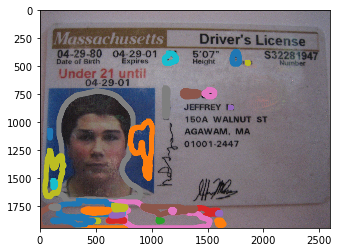

In [13]:
# Test plotting the image and polygons

import matplotlib.pyplot as plt

img = image.imread(path)

#plt.imshow(img.asnumpy())

"""
for poly in output[1][0]:
    #x,y = output[0][0][0][0].exterior.xy
    x,y = poly[0].exterior.xy
    #print(x)
    plt.plot(x,y)

#plt.show()
"""


#x,y = output[1][0][0][0].exterior.xy
fig, ax = plt.subplots()
ax.imshow(img.asnumpy()) #, extent=[0, 3000, 0, 3000])
#ax.autoscale(False)
for poly_type in output:
    for poly in poly_type[0]:
        x,y = poly[0].exterior.xy
        ax.plot(x,y ,  linewidth=5)
plt.show()


In [14]:
def simple_rule_based_obfuscation(output_deeplab):
    # Later we can save other things like the "sky" to decide to hide it
    true_output = []
    for poly in output_deeplab:
        if (poly[1] == "person, individual, someone, somebody, mortal, soul") or (poly[1] == "bookcase") or (poly[1] == "computer, computing machine, computing device, data processor, ") or (poly[1] == "trade name, brand name, brand, marque") :
            true_output.append(poly)
    return true_output

In [15]:
#print(type(output_pred_deeplab[0]))

In [16]:
list_true_output = []
for output in list_output:
    list_true_output.append(simple_rule_based_obfuscation(output))
#true_output = simple_rule_based_obfuscation(list_output)

In [17]:
print(list_true_output)

[[([(<shapely.geometry.polygon.Polygon object at 0x000001B439F9F048>, 0.0024550985544919968)], 'person, individual, someone, somebody, mortal, soul', 12)]]


In [18]:
### In the real outputs, we would simply have list of polygons that are private (i.e. that the approach told us to obfuscate)
### Hence we should reshape the outputs to this format in this case.

def predictions_to_private_segments(list_true_output):
    list_private_segments = []
    for pred_image in list_true_output:
        poly_for_image = []
        for private_elem in pred_image:
            for poly_in_private in private_elem[0]:
                poly_for_image.append(poly_in_private[0])
        list_private_segments.append(poly_for_image)
    return list_private_segments

In [19]:
list_true_output_reshape = predictions_to_private_segments(list_true_output)
print(list_true_output_reshape)

[[<shapely.geometry.polygon.Polygon object at 0x000001B439F9F048>]]


In [20]:
with open(Path('../test2017.json'), 'r') as f:
    ground_truth = json.load(f)
ground_truth = ground_truth['annotations']

In [21]:
evaluation_type = 'privacy_type'
parameter_interval = [0.1, 0.5, 0.8, 1.0]
eval_u.evaluate(ground_truth, list_true_output_reshape, evaluation_type, parameter_interval, list_img_name, list_img_shapes)#, path_image_folder)

TODO: read predictions.
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
nb non valid polygons: in GT:  0
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates
TODO: check order coordinates


({'a109_person_body': {0.1: 1.0, 0.5: 1.0, 0.8: 1.0, 1.0: 0.0},
  'a24_birth_date': {0.1: 0.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a106_address_current_all': {0.1: 0.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a32_drivers_license': {0.1: 1.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a8_signature': {0.1: 0.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a111_name_all': {0.1: 0.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a107_address_home_all': {0.1: 0.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0},
  'a105_face_all': {0.1: 1.0, 0.5: 0.0, 0.8: 0.0, 1.0: 0.0}},
 {'a109_person_body': 0.9491980827559842,
  'a24_birth_date': 0.0,
  'a106_address_current_all': 0.0,
  'a32_drivers_license': 0.18487154577379414,
  'a8_signature': 0.0,
  'a111_name_all': 0.0,
  'a107_address_home_all': 0.0,
  'a105_face_all': 1.0})

In [22]:
evaluation_type = 'instance_type'
parameter_interval = [4, 10, 16, 20]
eval_u.evaluate(ground_truth, list_true_output_reshape, evaluation_type, parameter_interval, list_img_name, list_img_shapes)#, path_image_folder)

2592 1944
TODO: check the validity / col/row
1296 972
(1296, 972)
TODO: check the sizes
(1296, 972)
TODO: check the sizes
(1296, 972)
TODO: check the sizes
(1296, 972)
TODO: check the sizes
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]]), array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]]), array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..

2592 1944
TODO: check the validity / col/row
648 486
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
(648, 486)
TODO: check the sizes
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]]), array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]]), array(

2592 1944
TODO: check the validity / col/row
518 486
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(2, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(2, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(2, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(518, 486)
TODO: check the sizes
(2, 486)
TODO: check the sizes
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]]), array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]]), array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
   

{4: {'precision': nan, 'recall': 0.0},
 10: {'precision': 1.0, 'recall': 0.1111111111111111},
 16: {'precision': 1.0, 'recall': 0.08333333333333333},
 20: {'precision': 1.0, 'recall': 0.16666666666666666}}

In [23]:
"""
def prepare_groundtruth_data(GT_file, list_image_names, list_ratio):
    with open(Path(GT_file), 'r') as f:
        ground_truth = json.load(f)
    ground_truth = ground_truth['annotations']    
    list_GT = []
    for im, im_ratio in zip(list_image_names, list_ratio):
        gt_dict = eval_u.GT_annotation_to_polygon_dict(ground_truth[im], im_ratio)                
        list_GT.append(gt_dict)
    #    for segments in ground_truth[im]["attributes"]:
    #        # Get the ground truth
    #        class_label = segments['attr_id']
        
    #        # Get polygons
        
    #        # Reshape polygons
    return list_GT
"""

'\ndef prepare_groundtruth_data(GT_file, list_image_names, list_ratio):\n    with open(Path(GT_file), \'r\') as f:\n        ground_truth = json.load(f)\n    ground_truth = ground_truth[\'annotations\']    \n    list_GT = []\n    for im, im_ratio in zip(list_image_names, list_ratio):\n        gt_dict = eval_u.GT_annotation_to_polygon_dict(ground_truth[im], im_ratio)                \n        list_GT.append(gt_dict)\n    #    for segments in ground_truth[im]["attributes"]:\n    #        # Get the ground truth\n    #        class_label = segments[\'attr_id\']\n        \n    #        # Get polygons\n        \n    #        # Reshape polygons\n    return list_GT\n'

In [24]:
#out = prepare_groundtruth_data('../test2017.json', list_image_names_deeplab, list_ratio)

In [25]:
#out